# Eye-Tracking Plotting Overview

Purpose
- Visualize key eye-tracking features per session as quality and behavior overview.

Inputs
- `./preprocessed/eye_tracking_features.csv` generated by `06_EyeEvents.ipynb`.

Quality Filters (applied before plotting)
- `roi_coverage >= 20` (% of gaze points inside text ROI)
- `pupil_size_mean >= 100` (remove blinks / tracking dropouts)
- `fixation_duration_mean <= 1.5 s` (cap unrealistic long fixations)

Outputs
- 2×3 boxplot grid by `session_id` for:
  - ROI Coverage (%), Number of Fixations, Mean Fixation Duration (s)
  - Number of Saccades, Mean Saccade Amplitude (px), Mean Pupil Size
- Saved to `./figures/eye_tracking_features_by_session_filtered.png`
- Displayed inline in notebook

Notes
- You can adjust filter thresholds in the parameters cell where `MIN_ROI`, `MIN_PUPIL`, and `MAX_FIX_DUR` are defined.
- For condition-wise plots (e.g., `alignment`), we can extend this notebook with additional facets.

Citation
- Based on analysis workflow adapted from: Chiossi, F., Mayer, S., & Ou, C. (2024). OSF: https://osf.io/fncj4/ (GPL-3.0).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [6]:
file_path = "./preprocessed/eye_tracking_features.csv"

df = pd.read_csv(file_path)
print("Loaded:", file_path, "shape=", df.shape)


Loaded: ./preprocessed/eye_tracking_features.csv shape= (126, 12)


In [7]:
print(sorted(df.columns.tolist()))
print("Sessions:", sorted(df['session_id'].unique().tolist()))

# Quality filters
MIN_ROI = 20.0         # % of gaze points inside ROI
MIN_PUPIL = 100.0      # raw pupil size threshold to remove blinks/dropouts
MAX_FIX_DUR = 1.5      # seconds; cap unrealistic long fixations

filtered = (
    df
      .query("roi_coverage >= @MIN_ROI")
      .query("pupil_size_mean >= @MIN_PUPIL")
      .query("fixation_duration_mean <= @MAX_FIX_DUR")
      .copy()
)
print(f"Filtered from {len(df)} to {len(filtered)} trials")


['duration', 'fixation_count', 'fixation_duration_mean', 'fixation_duration_total', 'pct_missing', 'pupil_size_mean', 'pupil_size_std', 'roi_coverage', 'saccade_amplitude_mean', 'saccade_count', 'session_id', 'trial_idx']
Sessions: [0, 1, 4, 7, 9, 13, 14, 15]
Filtered from 126 to 119 trials


✓ Saved figure to ./figures/eye_tracking_features_by_session_filtered.png


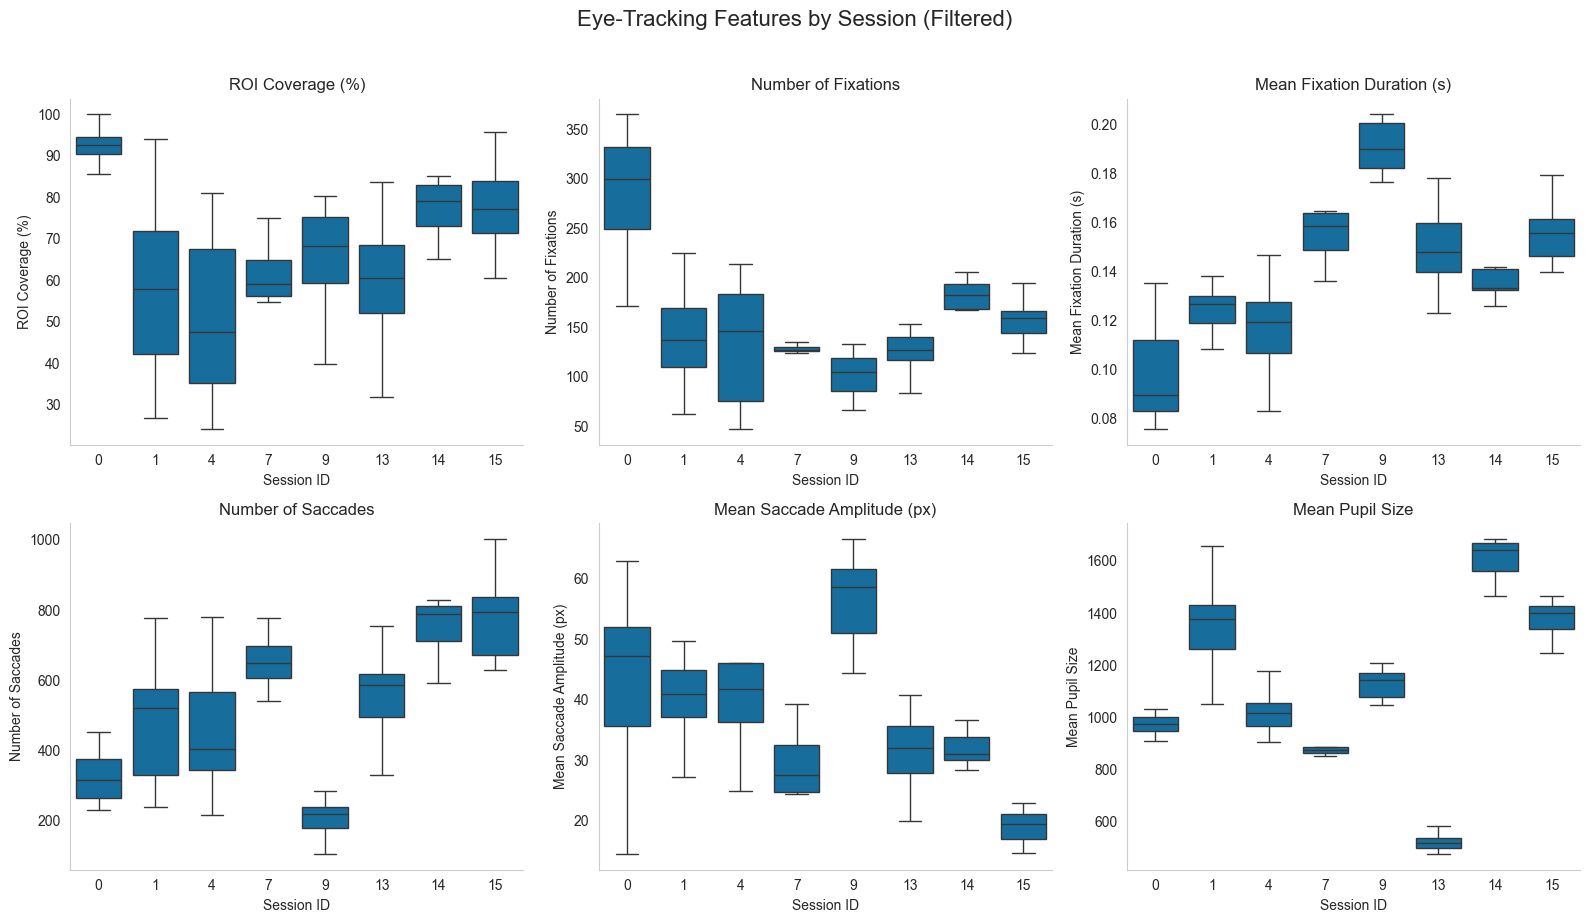

In [8]:
sns.set_palette("colorblind")
sns.set_style("whitegrid", {"axes.grid": False})

metrics = [
    ("roi_coverage", "ROI Coverage (%)"),
    ("fixation_count", "Number of Fixations"),
    ("fixation_duration_mean", "Mean Fixation Duration (s)"),
    ("saccade_count", "Number of Saccades"),
    ("saccade_amplitude_mean", "Mean Saccade Amplitude (px)"),
    ("pupil_size_mean", "Mean Pupil Size"),
]

fig, axes = plt.subplots(2, 3, figsize=(16, 9))
axes = axes.flatten()

for ax, (col, label) in zip(axes, metrics):
    sns.boxplot(x=filtered['session_id'].astype(str), y=filtered[col], showfliers=False, ax=ax)
    ax.set_xlabel('Session ID')
    ax.set_ylabel(label)
    ax.set_title(label)
    sns.despine(ax=ax)

fig.suptitle('Eye-Tracking Features by Session (Filtered)', fontsize=16, y=1.02)
fig.tight_layout()

# Save figure
output_path = "./figures/eye_tracking_features_by_session_filtered.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved figure to {output_path}")

plt.show()


## Spatial Gaze Distribution (Heatmaps)

Visualize where participants looked on the screen across all trials per session.

✓ Saved heatmap to ./figures/eye_tracking_heatmaps_by_session.png


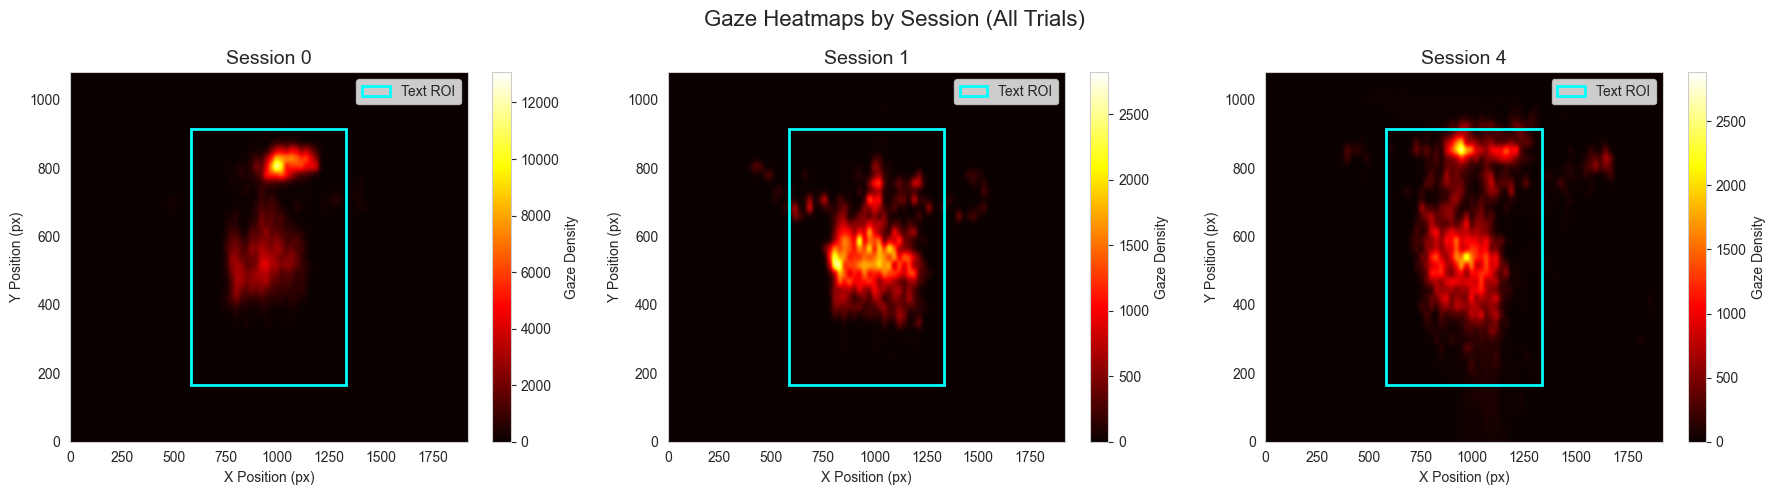

In [ ]:
import pickle
import numpy as np
from pathlib import Path

# Load all available session-level trial data
preprocessed_dir = Path("./preprocessed")
session_files = {}
for pkl_file in sorted(preprocessed_dir.glob("session_*-eye.pkl")):
    try:
        session_id = int(pkl_file.name.split('_')[1].split('-')[0])
        session_files[session_id] = str(pkl_file)
    except (ValueError, IndexError):
        continue

print(f"Found {len(session_files)} sessions: {sorted(session_files.keys())}")

# Screen dimensions (from 06_EyeEvents.ipynb)
SCREEN_WIDTH = 1920
SCREEN_HEIGHT = 1080
ROI_X1, ROI_Y1 = 585, 165
ROI_X2, ROI_Y2 = 1335, 915

# Collect gaze points from all sessions
all_sessions_x = []
all_sessions_y = []
session_heatmaps = {}

for session_id, filepath in sorted(session_files.items()):
    try:
        with open(filepath, 'rb') as f:
            trials = pickle.load(f)
        
        # Collect all gaze points for this session
        session_x, session_y = [], []
        for trial in trials:
            samples = trial['samples']
            # Average left and right eye for better coverage
            x = ((samples['x_left'] + samples['x_right']) / 2).dropna()
            y = ((samples['y_left'] + samples['y_right']) / 2).dropna()
            
            # Filter valid gaze points
            valid = (x >= 0) & (x < SCREEN_WIDTH) & (y >= 0) & (y < SCREEN_HEIGHT)
            session_x.extend(x[valid].values)
            session_y.extend(y[valid].values)
        
        all_sessions_x.extend(session_x)
        all_sessions_y.extend(session_y)
        
        # Create heatmap for this session
        if len(session_x) > 0:
            heatmap, _, _ = np.histogram2d(
                session_x, session_y,
                bins=[80, 45],
                range=[[0, SCREEN_WIDTH], [0, SCREEN_HEIGHT]]
            )
            session_heatmaps[session_id] = heatmap
    except Exception as e:
        print(f"  Error loading session {session_id}: {e}")

print(f"✓ Loaded gaze data from {len(session_heatmaps)} sessions")
print(f"  Total gaze points: {len(all_sessions_x):,}")

# Create average heatmap across all sessions
if len(all_sessions_x) > 0:
    avg_heatmap, xedges, yedges = np.histogram2d(
        all_sessions_x, all_sessions_y,
        bins=[80, 45],
        range=[[0, SCREEN_WIDTH], [0, SCREEN_HEIGHT]]
    )
    print(f"✓ Created average heatmap from {len(session_heatmaps)} sessions")
else:
    print("⚠️  No gaze data found")


In [ ]:
from matplotlib.patches import Rectangle
from scipy.ndimage import gaussian_filter

# Plot 1: Average heatmap across all sessions
fig, ax = plt.subplots(figsize=(12, 8))

# Smooth the heatmap for better visualization
avg_heatmap_smooth = gaussian_filter(avg_heatmap, sigma=1.5)

im = ax.imshow(
    avg_heatmap_smooth.T,
    origin='lower',
    extent=[0, SCREEN_WIDTH, 0, SCREEN_HEIGHT],
    cmap='hot',
    aspect='auto',
    interpolation='gaussian'
)

# Draw ROI rectangle
roi_rect = Rectangle(
    (ROI_X1, ROI_Y1), ROI_X2 - ROI_X1, ROI_Y2 - ROI_Y1,
    linewidth=3, edgecolor='cyan', facecolor='none', label='Text ROI', linestyle='--'
)
ax.add_patch(roi_rect)

ax.set_title(f'Average Gaze Heatmap (All {len(session_heatmaps)} Sessions)', fontsize=16, fontweight='bold')
ax.set_xlabel('X Position (pixels)', fontsize=12)
ax.set_ylabel('Y Position (pixels)', fontsize=12)
ax.legend(loc='upper right', fontsize=11)
cbar = plt.colorbar(im, ax=ax, label='Gaze Density (Count)')

fig.tight_layout()

# Save average heatmap
avg_heatmap_path = "./figures/eye_tracking_heatmap_average_all_sessions.png"
plt.savefig(avg_heatmap_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved average heatmap to {avg_heatmap_path}")

plt.show()

In [ ]:
# Plot 2: Per-session heatmaps for comparison
n_sessions = len(session_heatmaps)
n_cols = min(4, n_sessions)
n_rows = (n_sessions + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
if n_sessions == 1:
    axes = [axes]
else:
    axes = axes.flatten()

for idx, (session_id, heatmap) in enumerate(sorted(session_heatmaps.items())):
    ax = axes[idx]
    
    # Smooth individual heatmaps
    heatmap_smooth = gaussian_filter(heatmap, sigma=1.5)
    
    im = ax.imshow(
        heatmap_smooth.T,
        origin='lower',
        extent=[0, SCREEN_WIDTH, 0, SCREEN_HEIGHT],
        cmap='hot',
        aspect='auto',
        interpolation='gaussian'
    )
    
    # Draw ROI rectangle
    roi_rect = Rectangle(
        (ROI_X1, ROI_Y1), ROI_X2 - ROI_X1, ROI_Y2 - ROI_Y1,
        linewidth=2, edgecolor='cyan', facecolor='none', linestyle='--'
    )
    ax.add_patch(roi_rect)
    
    ax.set_title(f'Session {session_id}', fontsize=12, fontweight='bold')
    ax.set_xlabel('X Position (px)', fontsize=10)
    ax.set_ylabel('Y Position (px)', fontsize=10)
    plt.colorbar(im, ax=ax, label='Gaze Density')

# Hide unused subplots
for idx in range(n_sessions, len(axes)):
    axes[idx].axis('off')

fig.suptitle('Per-Session Gaze Heatmaps (All Trials)', fontsize=14, fontweight='bold')
fig.tight_layout()

# Save per-session heatmaps
session_heatmap_path = "./figures/eye_tracking_heatmaps_per_session.png"
plt.savefig(session_heatmap_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved per-session heatmaps to {session_heatmap_path}")

plt.show()

print("\n" + "="*80)
print("HEATMAP SUMMARY")
print("="*80)
print(f"Sessions analyzed: {len(session_heatmaps)}")
print(f"Total gaze points: {len(all_sessions_x):,}")
print(f"\nOutput files:")
print(f"  • {avg_heatmap_path}")
print(f"  • {session_heatmap_path}")